In [3]:
import networkx as nx
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display
import json
import os
from typing import Set, Dict, List, Optional, Tuple

class DFA:
    def __init__(self, file: Optional[str] = None) -> None:
        """
        Initialize the DFA with optional JSON file input.

        :param file: The path to a JSON file containing the DFA definition.
        :type file: Optional[str]
        """
        self._states: Set[str] = set()
        self._alphabet: Set[str] = set()
        self._transitions: Dict[Tuple[str, str], str] = {}
        self._start_state: Optional[str] = None
        self._accept_states: Set[str] = set()
        self._G = nx.MultiDiGraph()
        self._test_words: List[str] = []
        self._name: Optional[str] = None
        self._file_name: Optional[str] = None
        
        if file:
            self.import_from_json(file)
    
    @property
    def states(self) -> Set[str]:
        return self._states
    
    @states.setter
    def states(self, states: Set[str]) -> None:
        self._states = set(states)
    
    @property
    def alphabet(self) -> Set[str]:
        return self._alphabet
    
    @alphabet.setter
    def alphabet(self, alphabet: Set[str]) -> None:
        self._alphabet = set(alphabet)

    @property
    def start_state(self) -> Optional[str]:
        return self._start_state

    @start_state.setter
    def start_state(self, start_state: str) -> None:
        if start_state in self._states:
            self._start_state = start_state
        else:
            raise ValueError(f"Start state '{start_state}' must be one of the existing states.")

    @property
    def accept_states(self) -> Set[str]:
        return self._accept_states

    @accept_states.setter
    def accept_states(self, accept_states: Set[str]) -> None:
        if all(state in self._states for state in accept_states):
            self._accept_states = set(accept_states)
        else:
            raise ValueError("All accept states must be part of the existing states.")

    @property
    def transitions(self) -> Dict[Tuple[str, str], str]:
        return self._transitions

    def add_state(self, state: str, accepting: bool = False, starting: bool = False) -> None:
        """
        Add a state to the DFA.

        :param state: The state to add.
        :type state: str
        :param accepting: Whether the state is an accepting state. Defaults to False.
        :type accepting: bool
        :param starting: Whether the state is the start state. Defaults to False.
        :type starting: bool
        """
        if state in self._states:
            return
        self._states.add(state)
        self._G.add_node(state, shape='circle')
        if accepting:
            self._accept_states.add(state)
            self._G.nodes[state]['peripheries'] = '2'
        if starting:
            if self._start_state:
                raise ValueError("Start state is already defined.")
            self._start_state = state
            self._G.nodes[state]['style'] = 'filled'
            self._G.nodes[state]['fillcolor'] = 'lightgrey'
    
    def add_transition(self, from_state: str, to_state: str, symbol: str) -> None:
        """
        Add a transition from one state to another with a given symbol.

        :param from_state: The state from which the transition starts.
        :type from_state: str
        :param to_state: The state to which the transition goes.
        :type to_state: str
        :param symbol: The symbol that triggers the transition.
        :type symbol: str
        """
        if from_state not in self._states or to_state not in self._states:
            raise ValueError("Both states must be part of the DFA.")
        self._transitions[(from_state, symbol)] = to_state
        self._alphabet.add(symbol)
        self._G.add_edge(from_state, to_state, label=symbol)
    
    def validate_dfa(self) -> None:
        """
        Validate the DFA definition to ensure it follows DFA properties.

        :raises ValueError: If the DFA definition is invalid.
        """
        errors: List[str] = []
        if self._start_state not in self._states:
            errors.append(f"Start state '{self._start_state}' is not in the set of states.")
        for state in self._accept_states:
            if state not in self._states:
                errors.append(f"Accept state '{state}' is not in the set of states.")
        for (from_state, symbol), to_state in self._transitions.items():
            if from_state not in self._states:
                errors.append(f"Transition from state '{from_state}' is not in the set of states.")
            if to_state not in self._states:
                errors.append(f"Transition to state '{to_state}' is not in the set of states.")
            if symbol not in self._alphabet:
                errors.append(f"Transition symbol '{symbol}' is not in the alphabet.")
        if errors:
            raise ValueError("DFA validation errors:\n" + "\n".join(errors))
        else:
            print("DFA validation complete. No errors found.")
    
    def visualize(self) -> None:
        """
        Visualize the DFA using graph representation.
        """
        pydot_graph = to_pydot(self._G)
        pydot_graph.set_rankdir('LR')
        image_data = pydot_graph.create_png()
        if image_data is None:
            raise RuntimeError("Failed to generate PNG image from DFA graph.")
        display(Image(image_data))
    
    def simulate(self, words: Optional[List[str]] = None, verbose: bool = False) -> None:
        """
        Simulate the DFA on the input words.

        :param words: A list of words to simulate on the DFA. If None, use the test words from JSON.
        :type words: Optional[List[str]]
        :param verbose: Whether to print detailed simulation steps. Defaults to False.
        :type verbose: bool
        """
        if words is None:
            if self._test_words:
                words = self._test_words
            else:
                print("JSON has no words...")
                return
        for word in words:
            current_state = self._start_state
            if verbose:
                print(f"Simulating word '{word}' starting from state '{current_state}'")
            accepted = False
            for symbol in word:
                if (current_state, symbol) in self._transitions:
                    next_state = self._transitions[(current_state, symbol)]
                    if verbose:
                        print(f"Transition from state '{current_state}' using symbol '{symbol}' to state '{next_state}'")
                    current_state = next_state
                else:
                    if verbose:
                        print(f"No transition from state '{current_state}' on symbol '{symbol}', rejecting word.")
                    accepted = False
                    break
            else:
                if current_state in self._accept_states:
                    accepted = True
            print(f"Word '{word}' is {'accepted' if accepted else 'rejected'}.")
    
    def generate_words(self, max_length: int) -> List[str]:
        """
        Generate all words accepted by the DFA up to a certain length.

        :param max_length: The maximum length of words to generate.
        :type max_length: int
        :returns: A sorted list of words accepted by the DFA.
        :rtype: List[str]
        """
        accepted_words: Set[str] = set()
        queue: List[Tuple[str, str]] = [(self._start_state, "")]
        while queue:
            state, word = queue.pop(0)
            if state in self._accept_states and len(word) > 0:
                accepted_words.add(word)
            if len(word) >= max_length:
                continue
            for symbol in self._alphabet:
                if (state, symbol) in self._transitions:
                    next_state = self._transitions[(state, symbol)]
                    queue.append((next_state, word + symbol))
        return sorted(accepted_words)

    def permutations(self, length: int) -> None:
        """
        Generate all accepted words up to the given length and write them to a file.

        :param length: The maximum length of words to generate.
        :type length: int
        """

        if os.path.exists("permutations") is False:
            os.makedirs("permutations")
        
        words = self.generate_words(length)
        file_name = f"permutations/{self._name or self._file_name or 'dfa'}_permutations.txt"
        with open(file_name, 'w') as f:
            for word in words:
                f.write(f"{word}\n")
        print(f"Accepted words up to length {length} have been written to {file_name}.")
    
    def last_statement_of(self, word: str) -> str:
        """
        Simulate the word and return the last state.

        :param word: The word to simulate on the DFA.
        :type word: str
        :returns: The last state after simulating the word.
        :rtype: str
        """
        current_state = self._start_state
        for symbol in word:
            if (current_state, symbol) in self._transitions:
                current_state = self._transitions[(current_state, symbol)]
            else:
                print(f"Word '{word}' is rejected.")
                print(f"No transition from state '{current_state}' on symbol '{symbol}'.")
                return current_state
        if current_state in self._accept_states:
            print(f"Word '{word}' is accepted by the DFA.")
        else:
            print(f"Word '{word}' is rejected.")
            print(f"Ended on non-accepting state '{current_state}'.")
        return current_state
    
    def import_from_json(self, filename: str) -> None:
        """
        Import the DFA definition from a JSON file.

        :param filename: The path to the JSON file containing the DFA definition.
        :type filename: str
        """
        with open(filename, 'r') as f:
            dfa_dict = json.load(f)
        self.__init__()
        self._file_name = os.path.splitext(os.path.basename(filename))[0]
        self._name = dfa_dict.get('name', None)
        for state in dfa_dict['states']:
            accepting = state in dfa_dict['accept_states']
            starting = state == dfa_dict['start_state']
            self.add_state(state, accepting=accepting, starting=starting)
        for transition in dfa_dict['transitions']:
            self.add_transition(transition['from'], transition['to'], transition['symbol'])
        self._test_words = dfa_dict.get('test_words', [])
        print(f"DFA imported from {filename}")

DFA imported from jsons/dfa_0.json
DFA validation complete. No errors found.


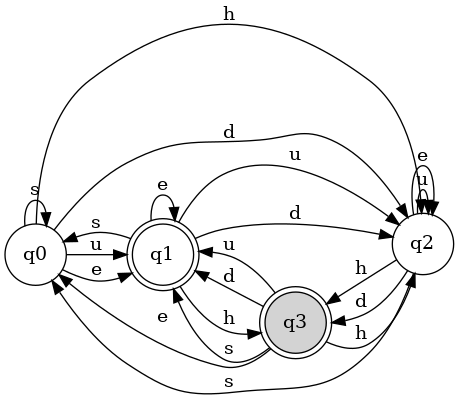

Word 'test' is rejected.
Word 'cica' is rejected.
Word 'mica' is rejected.
Word 'macska' is rejected.
Word 'cica' is rejected.
Word 'mica' is rejected.
Simulating word 'suse' starting from state 'q3'
Transition from state 'q3' using symbol 's' to state 'q1'
Transition from state 'q1' using symbol 'u' to state 'q2'
Transition from state 'q2' using symbol 's' to state 'q0'
Transition from state 'q0' using symbol 'e' to state 'q1'
Word 'suse' is accepted.
Accepted words up to length 6 have been written to permutations/dfa_0_permutations.txt.
Word 'suse' is accepted by the DFA.
Last state for seh: q1


In [4]:
if "dfa" in locals():
    del dfa
# Initialize DFA from JSON file
dfa = DFA(file="jsons/dfa_0.json")
    
dfa.validate_dfa()

# Visualize the DFA
dfa.visualize()

# Simulate using words from JSON
dfa.simulate()

# Simulate custom words
dfa.simulate(words=["cica", "mica"])

dfa.simulate(words=["suse"], verbose=True)

# Generate permutations up to length 4 and write to file
dfa.permutations(length=6)

# Get the last state after simulating a word
word = "seh"
last_state = dfa.last_statement_of(word="suse")
print(f"Last state for {word}: {last_state}")


DFA imported from jsons/test.json
DFA validation complete. No errors found.


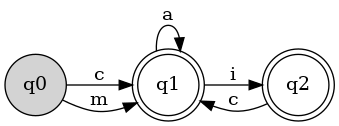

Word 'test' is rejected.
Word 'cica' is accepted.
Word 'mica' is accepted.
Word 'macska' is rejected.
Word 'cica' is accepted.
Word 'mica' is accepted.
Simulating word 'cica' starting from state 'q0'
Transition from state 'q0' using symbol 'c' to state 'q1'
Transition from state 'q1' using symbol 'i' to state 'q2'
Transition from state 'q2' using symbol 'c' to state 'q1'
Transition from state 'q1' using symbol 'a' to state 'q1'
Word 'cica' is accepted.
Simulating word 'suse' starting from state 'q0'
No transition from state 'q0' on symbol 's', rejecting word.
Word 'suse' is rejected.
Accepted words up to length 6 have been written to permutations/test_permutations.txt.
Word 'suse' is rejected.
No transition from state 'q0' on symbol 's'.
Last state for seh: q0


In [5]:
if "dfa" in locals():
    del dfa
dfa = DFA(file="jsons/test.json")

dfa.validate_dfa()
dfa.visualize()
dfa.simulate()
dfa.simulate(words=["cica", "mica"])
dfa.simulate(words=["cica"], verbose=True)
dfa.simulate(words=["suse"], verbose=True)
dfa.permutations(length=6)
word = "seh"
last_state = dfa.last_statement_of(word="suse")
print(f"Last state for {word}: {last_state}")

DFA imported from jsons/dfa_1.json
DFA validation complete. No errors found.


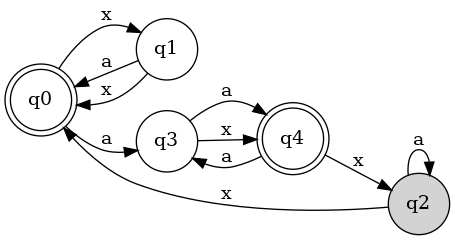

Word 'test' is rejected.
Word 'cica' is rejected.
Word 'mica' is rejected.
Word 'macska' is rejected.
Word 'cica' is rejected.
Word 'mica' is rejected.
Simulating word 'cica' starting from state 'q2'
No transition from state 'q2' on symbol 'c', rejecting word.
Word 'cica' is rejected.
Simulating word 'suse' starting from state 'q2'
No transition from state 'q2' on symbol 's', rejecting word.
Word 'suse' is rejected.
Simulating word 'ca' starting from state 'q2'
No transition from state 'q2' on symbol 'c', rejecting word.
Word 'ca' is rejected.
Accepted words up to length 6 have been written to permutations/dfa_1_permutations.txt.
Word 'suse' is rejected.
No transition from state 'q2' on symbol 's'.
Last state for seh: q2


In [6]:
if "dfa" in locals():
    del dfa
dfa = DFA(file="jsons/dfa_1.json")

dfa.validate_dfa()
dfa.visualize()
dfa.simulate()
dfa.simulate(words=["cica", "mica"])
dfa.simulate(words=["cica"], verbose=True)
dfa.simulate(words=["suse"], verbose=True)
dfa.simulate(words=["ca"], verbose=True)
dfa.permutations(length=6)
word = "seh"
last_state = dfa.last_statement_of(word="suse")
print(f"Last state for {word}: {last_state}")

DFA imported from jsons/dfa_2.json
DFA validation complete. No errors found.


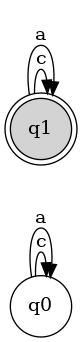

Word 'test' is rejected.
Word 'cica' is rejected.
Word 'mica' is rejected.
Word 'macska' is rejected.
Word 'cica' is rejected.
Word 'mica' is rejected.
Simulating word 'cica' starting from state 'q1'
Transition from state 'q1' using symbol 'c' to state 'q1'
No transition from state 'q1' on symbol 'i', rejecting word.
Word 'cica' is rejected.
Simulating word 'suse' starting from state 'q1'
No transition from state 'q1' on symbol 's', rejecting word.
Word 'suse' is rejected.
Simulating word 'ccaacc' starting from state 'q1'
Transition from state 'q1' using symbol 'c' to state 'q1'
Transition from state 'q1' using symbol 'c' to state 'q1'
Transition from state 'q1' using symbol 'a' to state 'q1'
Transition from state 'q1' using symbol 'a' to state 'q1'
Transition from state 'q1' using symbol 'c' to state 'q1'
Transition from state 'q1' using symbol 'c' to state 'q1'
Word 'ccaacc' is accepted.
Accepted words up to length 6 have been written to permutations/dfa_2_permutations.txt.
Word 'cca

In [7]:
if "dfa" in locals():
    del dfa
dfa = DFA(file="jsons/dfa_2.json")

dfa.validate_dfa()
dfa.visualize()
dfa.simulate()
dfa.simulate(words=["cica", "mica"])
dfa.simulate(words=["cica"], verbose=True)
dfa.simulate(words=["suse"], verbose=True)
dfa.simulate(words=["ccaacc"], verbose=True)
dfa.permutations(length=6)
word = "seh"
last_state = dfa.last_statement_of(word="ccaacc")
print(f"Last state for {word}: {last_state}")